In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import os

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')


import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
data = pd.read_csv('C:/Users/Imran/OneDrive - Ontario Tech University/Documents/Capstone/final_df.csv')

In [3]:
labels = data['rar']

In [4]:
features = data.drop('rar', axis=1)

In [5]:
# Standardize the data
scaler = StandardScaler().fit(features)
features_scaled = scaler.transform(features)

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

### Creating the individual model

In [7]:
# Define and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

### Creating the hybrid model

In [8]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

In [18]:
data_km = pd.DataFrame(features_scaled)

In [22]:
# Create a DataFrame to hold the features and clusters

data_km['label'] = labels
data_km['cluster'] = clusters

In [24]:
# Function to train Gradient Boosting on a specific cluster
def train_gb_on_cluster(cluster_data):
    features = cluster_data.drop(['label', 'cluster'], axis=1)
    labels = cluster_data['label']
    
    X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gb_model.fit(X_train_cluster, y_train_cluster)
    
    return gb_model

In [26]:
# Train a Gradient Boosting model for each cluster
gb_models = {}
for cluster in range(3):
    cluster_data = data_km[data_km['cluster'] == cluster]
    gb_models[cluster] = train_gb_on_cluster(cluster_data)

In [27]:
# Assign each sample in the test set to a cluster
test_clusters = kmeans.predict(X_test)

In [28]:
# Initialize an array to hold the predictions
combined_predictions = np.zeros_like(y_test)

In [36]:
# Make predictions using the corresponding model for each cluster
for cluster in range(3):
    cluster_indices = np.where(test_clusters == cluster)[0]
    if len(cluster_indices) > 0:
        X_cluster = X_test[cluster_indices]  # Use NumPy indexing
        model = gb_models[cluster]
        combined_predictions[cluster_indices] = model.predict(X_cluster).flatten()

# Evaluate the combined performance
combined_mse = mean_squared_error(y_test, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(y_test, combined_predictions)
combined_r2 = r2_score(y_test, combined_predictions)

print(f'Combined Model MSE: {combined_mse}')
print(f'Combined Model RMSE: {combined_rmse}')
print(f'Combined Model MAE: {combined_mae}')
print(f'Combined Model R²: {combined_r2}')

Combined Model MSE: 256090.75311850553
Combined Model RMSE: 506.0541009798315
Combined Model MAE: 246.88698681803825
Combined Model R²: 0.9972153082000393


In [38]:
# Evaluate the model
predictions = gb_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print additional metrics
print(f"Single Model MSE: {mse}")
print(f"Single Model RMSE: {rmse}")
print(f"Single Model MAE: {mae}")
print(f"Single Model R²: {r2}")

Single Model MSE: 382149.6482876455
Single Model RMSE: 618.1825363819698
Single Model MAE: 336.87116336474554
Single Model R²: 0.9958445629957907


In [40]:
#create a dataframe of scores
performance_metrics = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Single Model': [mse, rmse, mae, r2],
    'Combined Model': [combined_mse, combined_rmse, combined_mae, combined_r2]
})

In [47]:
# Export the performance metrics to a CSV file
performance_metrics.to_csv('performance_metrics_GB_Original.csv', index=False)

In [53]:
# Get feature importances
importances = gb_model.feature_importances_

# Get the indices that would sort the importances array in descending order
sorted_indices = np.argsort(importances)[::-1]

# Display top 5 feature importance
top_n = 5
for i in range(top_n):
    print(f"Feature {sorted_indices[i]}: Importance {importances[sorted_indices[i]]}")

Feature 45: Importance 0.8132166331346921
Feature 41: Importance 0.1253191943487625
Feature 21: Importance 0.04333602372967905
Feature 20: Importance 0.005701787039375886
Feature 17: Importance 0.00460045737456232


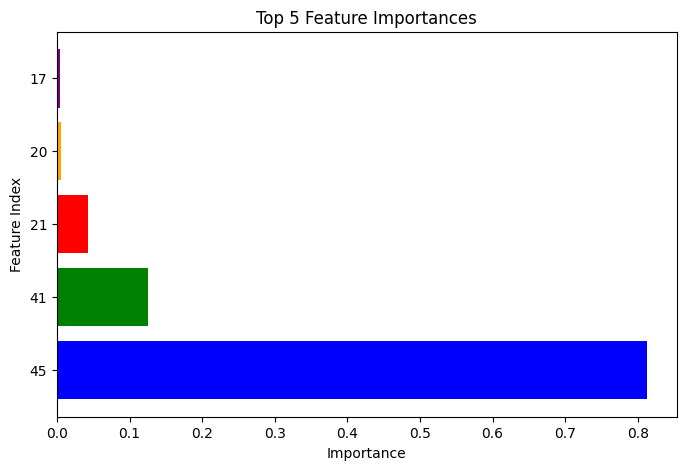

In [55]:
# Define colors for bars
colors = ['blue', 'green', 'red', 'orange', 'purple']

# Plot horizontal bar chart of top 5 feature importances with different colors
top_n = 5
plt.figure(figsize=(8, 5))
plt.barh(range(top_n), importances[sorted_indices][:top_n], align='center', color=colors)
plt.yticks(range(top_n), sorted_indices[:top_n])
plt.xlabel('Importance')
plt.ylabel('Feature Index')
plt.title('Top 5 Feature Importances')
plt.show()

In [57]:
# Get feature importances
importances = model.feature_importances_

# Get the indices that would sort the importances array in descending order
sorted_indices = np.argsort(importances)[::-1]

# Display top 5 feature importance
top_n = 5
for i in range(top_n):
    print(f"Feature {sorted_indices[i]}: Importance {importances[sorted_indices[i]]}")

Feature 45: Importance 0.9306559460088338
Feature 21: Importance 0.018755964778043734
Feature 17: Importance 0.016497637182545183
Feature 20: Importance 0.00863100741630175
Feature 33: Importance 0.007872989542192043


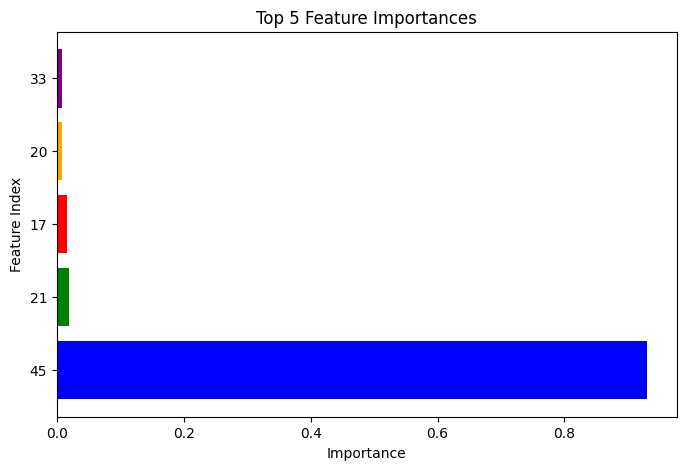

In [59]:
# Define colors for bars
colors = ['blue', 'green', 'red', 'orange', 'purple']

# Plot horizontal bar chart of top 5 feature importances with different colors
top_n = 5
plt.figure(figsize=(8, 5))
plt.barh(range(top_n), importances[sorted_indices][:top_n], align='center', color=colors)
plt.yticks(range(top_n), sorted_indices[:top_n])
plt.xlabel('Importance')
plt.ylabel('Feature Index')
plt.title('Top 5 Feature Importances')
plt.show()